In [15]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import os
from datetime import datetime, timedelta
import pickle
import numpy as np

In [4]:
DATA_DIR = "../data"
def read_from_data_dir(name):
    return os.path.join(DATA_DIR, name)

In [5]:

players = pd.read_csv(read_from_data_dir("players.csv"))
players = players[~players["functional_role"].isna()]
games = pd.read_csv(read_from_data_dir("games.csv"))
games = games[games["outcome"].isin([0, 1])]
handles = pd.read_csv(read_from_data_dir("handles.csv"))
roles = pd.read_csv(read_from_data_dir("roles.csv"))

In [6]:
role_to_team = dict(zip(roles["role"], roles["team"]))
role_to_name = dict(zip(roles["role"], roles["role_name"]))

In [7]:
with open(read_from_data_dir("full_balance.pkl"), 'rb') as f:
    full_balance = pickle.load(f)
full_balance

survivor_mmrs  \
0      [1217.0, 1145.2142857142858, 1975.45, 1133.333...   
1      [1207.57805907173, 1474.1666666666667, 1092.35...   
2      [1555.1549295774648, 1973.75, 1115.0, 1442.574...   
3      [2095.7916666666665, 1594.2119733424242, 2012....   
4      [1013.7575757575758, 1534.7411035431326, 1481....   
...                                                  ...   
19005  [1125.1267383542095, 1254.50377010841, 1464.68...   
19006  [1222.8336796580013, 2044.6125468038836, 2028....   
19007  [1026.0, 1024.0456172639965, 2320.045617898883...   
19008  [1204.0678609759386, 1543.4048351661702, 1531....   
19009  [1492.101367241271, 1293.6077668805601, 1493.0...   

                        survivor_roles  \
0       [25, 3, 24, 3, 12, 38, 12, 18]   
1       [31, 23, 3, 31, 24, 3, 35, 24]   
2      [24, 26, 12, 14, 37, 25, 36, 1]   
3      [21, 26, 21, 25, 3, 36, 37, 11]   
4         [8, 23, 1, 18, 29, 4, 12, 7]   
...                                ...   
19005       [12, 18, 36, 19, 25, 6, 1]   
19006    [12, 29, 10, 21, 3, 3, 26, 3]   
19007       [3, 3, 22, 3, 4, 8, 12, 3]   
19008   [6, 19, 19, 3, 23, 19, 19, 18]   
19009    [12, 1, 3, 23, 24, 18, 6, 36]   

                                  kerrigan_mmrs kerrigan_roles  outcome  \
0                             [1765.25, 1414.4]        [33, 9]        1   
1                  [1252.5, 1439.7777777777778]       [28, 34]        0   
2       [1523.6363636363637, 1153.608695652174]       [34, 20]        0   
3                    [1959.7878787878788, 2084]        [9, 27]        1   
4       [1067.6666666666667, 1903.090909090909]       [32, 16]        0   
...                                         ...            ...      ...   
19005  [1048.2576606163448, 1230.3647889456108]       [20, 34]        0   
19006   [1288.118794433907, 1742.2955548563498]       [32, 34]        1   
19007   [783.5081573651095, 1500.6576185570907]        [9, 13]        0   
19008  [1214.2255683916433, 1120.6333405514254]       [34, 20]        0   
19009  [1179.7161637052463, 1531.5372607674822]        [0, 20]        0   

       predicted    datetime_of_game  
0       0.777536 2022-05-16 18:00:28  
1       0.299213 2022-05-16 18:03:35  
2       0.384629 2022-05-16 18:09:49  
3       0.925327 2022-05-16 18:29:24  
4       0.486085 2022-05-16 19:03:39  
...          ...                 ...  
19005   0.101356 2022-07-28 02:00:30  
19006   0.445581 2022-07-28 02:14:33  
19007   0.169363 2022-07-28 02:16:29  
19008   0.103876 2022-07-28 02:20:23  
19009   0.356310 2022-07-28 02:38:53  

[19010 rows x 7 columns]

In [8]:
roles

role     role_name  team
0      0      Kerrigan     1
1      1     Scientist     0
2      2  Dark Templar     0
3      3     Ascendant     0
4      4        Spirit     0
5      5          Ares     0
6      6       Prophet     0
7      7        Stukov     0
8      8       Artanis     0
9      9        Zagara     1
10    10      Engineer     0
11    11     Team Nova     0
12    12         Nomad     0
13    13        Dehaka     1
14    14        Helios     0
15    15        Random     0
16    16       Thakras     1
17    17         Swann     0
18    18        Warden     0
19    19      Selendis     0
20    20        Niadra     1
21    21          Mira     0
22    22         Scion     0
23    23    Technician     0
24    24      Warfield     0
25    25      Champion     0
26    26  Elementalist     0
27    27         Brakk     1
28    28        Glevig     1
29    29   Delta Squad     0
30    30      Phaegore     1
31    31        Alarak     0
32    32         Izsha     1
33    33         Malus     1
34    34        Kraith     1
35    35     Energizer     0
36    36         Andor     0
37    37            DJ     0
38    38   Rattlesnake     0
39    39     SgtHammer     0

In [22]:
def balance_contains(row, this_role, mmr_range):
    
    roles = row["survivor_roles"] + row["kerrigan_roles"]
    mmrs = row["survivor_mmrs"] + row["kerrigan_mmrs"]
    
    for r, m in zip(roles, mmrs):
        if r == this_role and m >= mmr_range[0] and m < mmr_range[1]:
            return True
    return False
    
def filter_set(a_role, mmr_range):
    return full_balance.apply(lambda row: balance_contains(row, a_role, mmr_range), axis=1)

net_bias = np.mean(full_balance['outcome'] - full_balance['predicted'])

def relative_win_rate(pick_role, mmr_range):
    select_criteria = filter_set(pick_role, mmr_range)
    filtered = full_balance[select_criteria]
    
    # flip to correct team perspective
    outcomes = filtered['outcome'] if role_to_team[pick_role] == 1 else filtered['outcome'].apply(lambda x : 1 - x)
    
    predicted = filtered['predicted'] if role_to_team[pick_role] == 1 else filtered['predicted'].apply(lambda x: 1 - x)

    bias = net_bias if role_to_team[pick_role] == 1 else - net_bias
    
    in_set = np.mean(outcomes - predicted) + net_bias
    return in_set, len(filtered)

In [23]:
for i in range(40):
    print(role_to_name[i], "{:2.2f}%".format(relative_win_rate(i, (0, 5000)) * 100))

TypeError: unsupported format string passed to tuple.__format__

In [ ]:
select_role = 1
mmr_band = 100
mmr_min = 1000
mmr_max = 2500
mmr_interval = 25

In [26]:
def get_to_plot(which_class):
    to_plot = []
    for center in range(mmr_min, mmr_max, mmr_interval):
        low = center - 50
        high = center + 50
        result, num_samples = relative_win_rate(which_class, (low, high))
        to_plot.append((center, result))
        print(low, high, result, num_samples)
    return to_plot
    
to_plot_sci = get_to_plot(1)
to_plot_engi = get_to_plot(10)
to_plot_spirit = get_to_plot(4)
to_plot_ares = get_to_plot(5)

950 1050 -0.0014382409429518454 1089
975 1075 -0.0016887362386334929 1246
1000 1100 0.00842475339450186 1379
1025 1125 0.010196420207333195 1460
1050 1150 0.007842273810728122 1495
1075 1175 0.013735496298066608 1456
1100 1200 0.012322408778431678 1409
1125 1225 0.012715183066310873 1310
1150 1250 0.004304682185123114 1292
1175 1275 -0.009102000323305109 1220
1200 1300 -0.01234658427995094 1115
1225 1325 -0.024363127460861934 1047
1250 1350 -0.015084283664491443 911
1275 1375 -0.0014578804942589757 805
1300 1400 0.007237140321805896 818
1325 1425 0.021838864023412452 781
1350 1450 0.02514584095122522 805
1375 1475 0.010251758317794414 823
1400 1500 -0.00925008475279392 752
1425 1525 -0.01384444367311484 692
1450 1550 -0.035764005649891704 625
1475 1575 -0.004180363375669133 596
1500 1600 -0.005997269207708857 554
1525 1625 0.001756232634832924 567
1550 1650 0.021357536565670243 538
1575 1675 0.008688522877664322 522
1600 1700 0.02107215916505506 511
1625 1725 0.02659060938930044 500
16

2350 2450 -0.19032072206095577 6
2375 2475 -0.14973990238960308 6
2400 2500 -0.0016186266057761581 6
2425 2525 0.005753283310624751 6


In [31]:
x_axis = np.array(to_plot_sci)[:, 0]
y_engi = np.array(to_plot_engi)[:, 1]
y_sci = np.array(to_plot_sci)[:, 1]
y_spirit = np.array(to_plot_spirit)[:, 1]
y_ares = np.array(to_plot_ares)[:, 1]

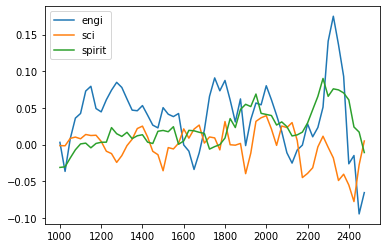

In [33]:
plt.plot(x_axis, y_engi, label="engi")
plt.plot(x_axis, y_sci, label="sci")
plt.plot(x_axis, y_spirit, label="spirit")
#plt.plot(x_axis, y_ares, label="ares")
plt.legend()